In [9]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
stock = yf.Ticker("AAPL") 
data = stock.history(start="2015-01-01", end="2025-01-01", auto_adjust=False) 

In [3]:
ts_data = data['Close']

In [4]:
ts_data.head()

Date
2015-01-02 00:00:00-05:00    27.332500
2015-01-05 00:00:00-05:00    26.562500
2015-01-06 00:00:00-05:00    26.565001
2015-01-07 00:00:00-05:00    26.937500
2015-01-08 00:00:00-05:00    27.972500
Name: Close, dtype: float64

In [5]:
train_size = int(len(ts_data) * 0.8)
train_data = ts_data[:train_size]
test_data = ts_data[train_size:]

In [6]:
train_data.shape, test_data.shape

((2012,), (504,))

In [10]:
from statsmodels.tsa.stattools import adfuller
def check_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    if dftest[1] <= 0.05:
        print("-> Series is Stationary (rejecting H0)")
    else:
        print("-> Series is Non-Stationary (failing to reject H0)")

check_stationarity(train_data)

Results of Dickey-Fuller Test:
Test Statistic                   -0.722118
p-value                           0.840937
#Lags Used                       20.000000
Number of Observations Used    1991.000000
Critical Value (1%)              -3.433639
Critical Value (5%)              -2.862993
Critical Value (10%)             -2.567543
dtype: float64
-> Series is Non-Stationary (failing to reject H0)


In [12]:
train_data_diff1 = train_data.diff().dropna()
check_stationarity(train_data_diff1)

Results of Dickey-Fuller Test:
Test Statistic                -9.119995e+00
p-value                        3.224528e-15
#Lags Used                     1.900000e+01
Number of Observations Used    1.991000e+03
Critical Value (1%)           -3.433639e+00
Critical Value (5%)           -2.862993e+00
Critical Value (10%)          -2.567543e+00
dtype: float64
-> Series is Stationary (rejecting H0)


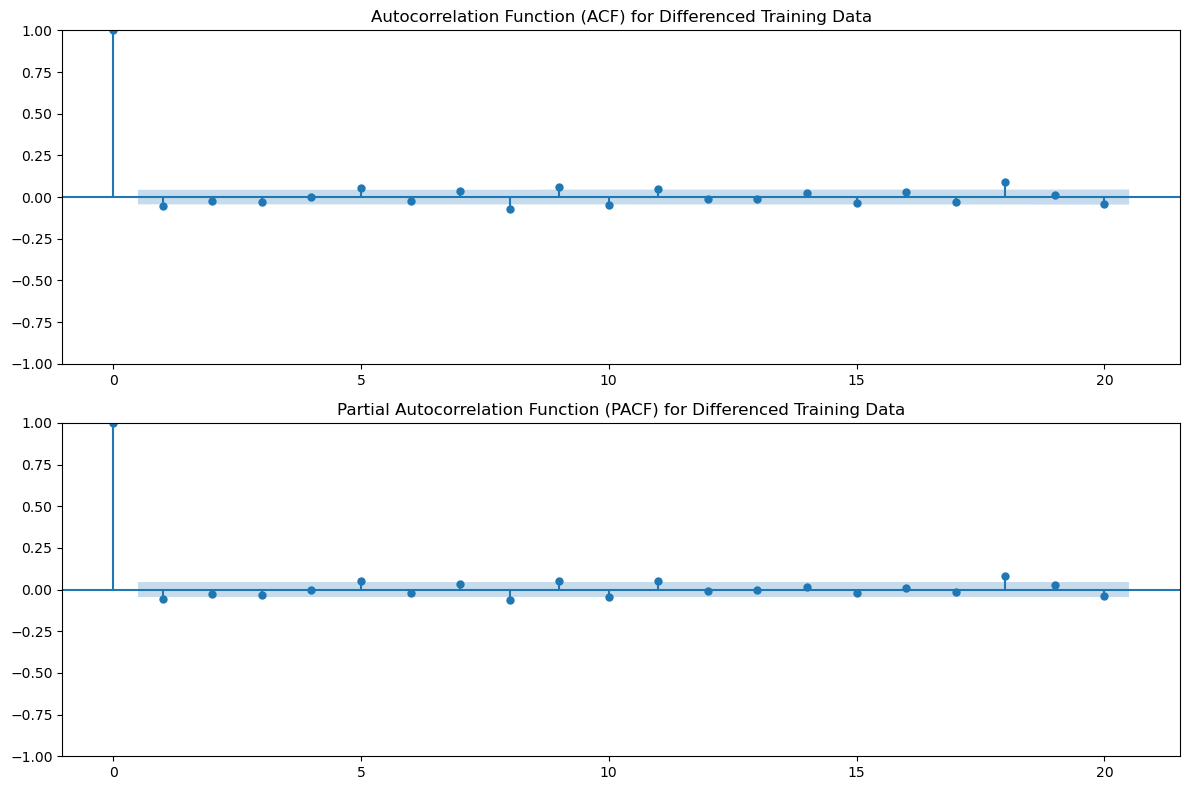

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1) # 2 տող, 1 սյուն, 1-ին գրաֆիկ
plot_acf(train_data_diff1, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) for Differenced Training Data')

plt.subplot(2, 1, 2) # 2 տող, 1 սյուն, 2-րդ գրաֆիկ
plot_pacf(train_data_diff1, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) for Differenced Training Data')

plt.tight_layout() # Գրաֆիկները կոկիկ դասավորելու համար
plt.show()

In [14]:
from pmdarima import auto_arima

print("\nՈրոնում ենք լավագույն ARIMA պարամետրերը auto_arima-ի միջոցով...")

# Օգտագործել auto_arima մարզման տվյալների վրա
# start_p, start_q - p և q-ի սկզբնական արժեքները որոնման համար
# max_p, max_q - p և q-ի առավելագույն արժեքները
# d - դիֆերենցման կարգը (None դեպքում auto_arima-ն ինքն է որոշում)
# seasonal - սեզոնային բաղադրիչի առկայությունը (False բաժնետոմսերի համար)
# stepwise - արագ որոնման համար
# suppress_warnings - զգուշացումները թաքցնելու համար
# error_action - սխալի դեպքում անցնել հաջորդին
# trace - ցույց տալ որոնման ընթացքը

stepwise_fit = auto_arima(train_data, start_p=1, start_q=1,
                          max_p=5, max_q=5,
                          d=None, # Թող auto_arima-ն ինքը որոշի d-ն
                          seasonal=False,
                          stepwise=True,
                          suppress_warnings=True,
                          error_action='ignore',
                          trace=True)

print("\nauto_arima-ի կողմից առաջարկվող լավագույն ARIMA մոդելը:")
print(stepwise_fit.summary())


Որոնում ենք լավագույն ARIMA պարամետրերը auto_arima-ի միջոցով...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8021.743, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8026.138, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8022.196, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8021.833, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8025.670, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8023.582, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8023.605, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8022.182, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8022.570, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8022.162, Time=1.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=8021.657, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=8021.572, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=8022.036, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]           

In [18]:
from statsmodels.tsa.arima.model import ARIMA
# ARIMA մոդելի պարամետրերը auto_arima-ից
p, d, q = 0, 1, 1

print(f"\nՀամապատասխանեցնում ենք ARIMA({p}, {d}, {q}) մոդելը մարզման տվյալներին...")
model = ARIMA(train_data, order=(p,d,q))
results = model.fit()

results.summary()


Համապատասխանեցնում ենք ARIMA(0, 1, 1) մոդելը մարզման տվյալներին...


/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2012
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -4008.786
Date:                Tue, 22 Apr 2025   AIC                           8021.572
Time:                        22:50:17   BIC                           8032.785
Sample:                             0   HQIC                          8025.688
                               - 2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0568      0.013     -4.498      0.000      -0.082      -0.032
sigma2         3.1550      0.047     66.622      0.000       3.062       3.248
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4274.22
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              42.57   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
# Կանխատեսում կատարելը թեստային հատվածի համար
# Որոշել կանխատեսման սկզբի և ավարտի ինդեքսները՝ օգտագործելով test_data-ի ինդեքսները

start_index = test_data.index[0]
end_index = test_data.index[-1]

print(f"\nԿատարում ենք կանխատեսումներ {start_index} -ից մինչև {end_index} ժամանակահատվածի համար ({len(test_data)} քայլով)...")

predictions = results.predict(start=start_index, end=end_index)

print("\nԿանխատեսումներն ավարտված են։")
print("Կանխատեսված առաջին 5 արժեքները:")
print(predictions.head())


Կատարում ենք կանխատեսումներ 2022-12-29 00:00:00-05:00 -ից մինչև 2024-12-31 00:00:00-05:00 ժամանակահատվածի համար (504 քայլով)...


KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [20]:
# Կանխատեսում կատարելը թեստային հատվածի համար՝ օգտագործելով թվային ինդեքսներ
# start ինդեքսը test_data-ի սկզբի դիրքն է ամբողջ ts_data-ի մեջ
start_index_num = len(train_data)
# end ինդեքսը test_data-ի վերջի դիրքն է ամբողջ ts_data-ի մեջ
end_index_num = len(ts_data) - 1

print(f"\nԿատարում ենք կանխատեսումներ թվային ինդեքսներով՝ {start_index_num} -ից մինչև {end_index_num}...")

# Օգտագործել թվային ինդեքսները predict ֆունկցիայում
predictions = results.predict(start=start_index_num, end=end_index_num)

# predictions օբյեկտի ինդեքսները կարող են չհամապատասխանել test_data-ի ամսաթվերին։
# Որպեսզի պատկերենք և գնահատենք ճիշտ, պետք է predictions-ի ինդեքսները դարձնենք test_data-ի ինդեքսները։
predictions.index = test_data.index

print("\nԿանխատեսումներն ավարտված են։")
print("Կանխատեսված առաջին 5 արժեքները:")
print(predictions.head(10))


Կատարում ենք կանխատեսումներ թվային ինդեքսներով՝ 2012 -ից մինչև 2515...

Կանխատեսումներն ավարտված են։
Կանխատեսված առաջին 5 արժեքները:
Date
2022-12-29 00:00:00-05:00    126.272575
2022-12-30 00:00:00-05:00    126.272575
2023-01-03 00:00:00-05:00    126.272575
2023-01-04 00:00:00-05:00    126.272575
2023-01-05 00:00:00-05:00    126.272575
Name: predicted_mean, dtype: float64


/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [21]:
predictions.head(10)

Date
2022-12-29 00:00:00-05:00    126.272575
2022-12-30 00:00:00-05:00    126.272575
2023-01-03 00:00:00-05:00    126.272575
2023-01-04 00:00:00-05:00    126.272575
2023-01-05 00:00:00-05:00    126.272575
2023-01-06 00:00:00-05:00    126.272575
2023-01-09 00:00:00-05:00    126.272575
2023-01-10 00:00:00-05:00    126.272575
2023-01-11 00:00:00-05:00    126.272575
2023-01-12 00:00:00-05:00    126.272575
Name: predicted_mean, dtype: float64

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [23]:
rmse = np.sqrt(mean_squared_error(test_data, predictions))
print(f"\nRMSE (Root Mean Squared Error) on test data: {rmse}")
mae = mean_absolute_error(test_data, predictions) 
print(f"MAE (Mean Absolute Error) on test data: {mae}") # Ավելացված MAE ելքը


RMSE (Root Mean Squared Error) on test data: 69.35216782696568
MAE (Mean Absolute Error) on test data: 63.444866241196955


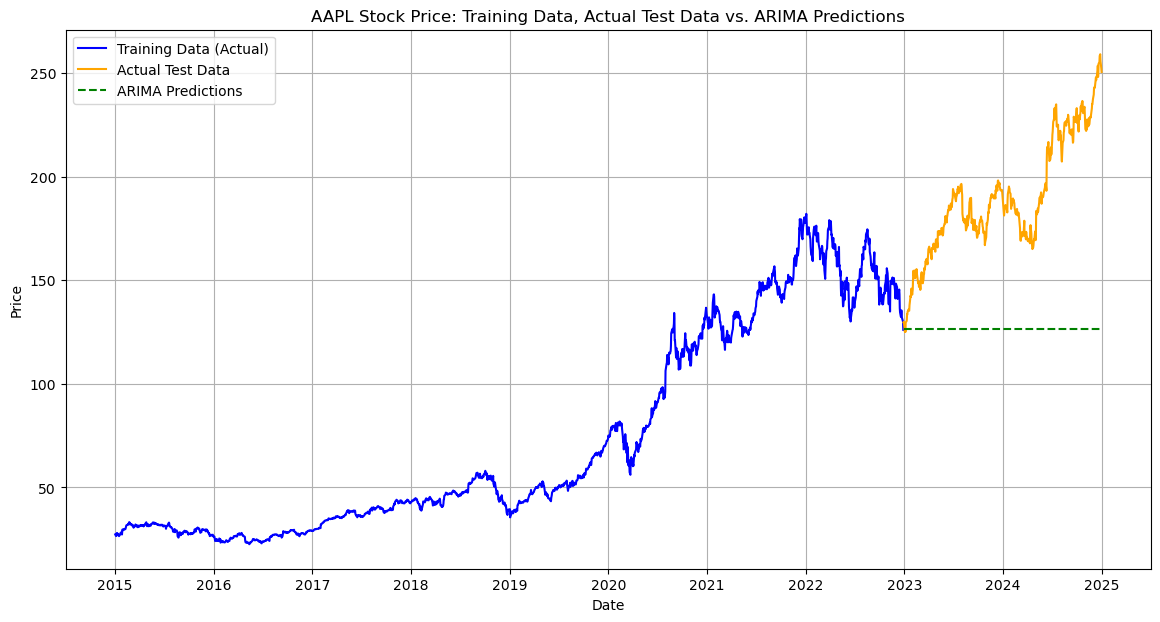

In [24]:
plt.figure(figsize=(14, 7))
plt.plot(train_data, label='Training Data (Actual)', color='blue')
plt.plot(test_data, label='Actual Test Data', color='orange')
plt.plot(predictions.index, predictions, label='ARIMA Predictions', color='green', linestyle='--')

plt.title('AAPL Stock Price: Training Data, Actual Test Data vs. ARIMA Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()